In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import pylab
import pickle
import numpy as np
import time
import itertools
from tqdm.notebook import tqdm
from multiprocessing import Pool
import matplotlib.cm as cm
import scipy
import community as community_louvain
import seaborn as sns
import pickle
import os
from collections import defaultdict
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
from sklearn.metrics import accuracy_score,classification_report
import keras

import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1


     |████████████████████████████████| 440kB 14.2MB/s 
     |████████████████████████████████| 235kB 46.5MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 


In [ ]:
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
from stellargraph import StellarGraph,StellarDiGraph

In [ ]:
from stellargraph import datasets, utils
from tensorflow.keras import callbacks, optimizers, losses, metrics, regularizers, Model
import numpy as np
import pandas as pd

from stellargraph.mapper import KGTripleGenerator
from stellargraph.layer import ComplEx

from IPython.display import HTML

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/gnn

/content/drive/MyDrive/gnn


In [ ]:
df = pd.read_csv('soc-redditHyperlinks-body.tsv',sep='\t')

In [ ]:
print(df.columns)
print(df['LINK_SENTIMENT'].values[0:10])

Index(['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT', 'POST_ID', 'TIMESTAMP',
       'LINK_SENTIMENT', 'PROPERTIES'],
      dtype='object')
[ 1 -1  1  1  1  1  1  1  1  1]


In [ ]:
nodes = df['SOURCE_SUBREDDIT'].unique().tolist()
nodes.extend(df['TARGET_SUBREDDIT'].unique().tolist())


In [ ]:
reddit_edges = pd.DataFrame(
    {"source": df['SOURCE_SUBREDDIT'], "target": df['TARGET_SUBREDDIT']}
)
print(reddit_edges)

                     source             target
0           leagueoflegends    teamredditteams
1                theredlion             soccer
2              inlandempire             bikela
3                       nfl                cfb
4                playmygame            gamedev
...                     ...                ...
286556           negareddit      debatefascism
286557          mildlynomil          justnomil
286558               mmorpg  blackdesertonline
286559  electricskateboards          askreddit
286560                mgtow    dataisbeautiful

[286561 rows x 2 columns]


In [ ]:
df['LINK_SENTIMENT'][df['LINK_SENTIMENT']==-1]="neg"
df['LINK_SENTIMENT'][df['LINK_SENTIMENT']==1]="pos"

neglen=df['LINK_SENTIMENT'][df['LINK_SENTIMENT']=="neg"].shape[0]
poslen=df['LINK_SENTIMENT'][df['LINK_SENTIMENT']=="pos"].shape[0]


reddit_edges = reddit_edges.assign(
    label=df['LINK_SENTIMENT']
)
print(reddit_edges)
print(neglen,poslen)

total=neglen+poslen
weight_for_0 = (1 / neglen)*(total)/2.0 
weight_for_1 = (1 / poslen)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

                     source             target label
0           leagueoflegends    teamredditteams   pos
1                theredlion             soccer   neg
2              inlandempire             bikela   pos
3                       nfl                cfb   pos
4                playmygame            gamedev   pos
...                     ...                ...   ...
286556           negareddit      debatefascism   pos
286557          mildlynomil          justnomil   pos
286558               mmorpg  blackdesertonline   pos
286559  electricskateboards          askreddit   pos
286560                mgtow    dataisbeautiful   pos

[286561 rows x 3 columns]
21070 265491
Weight for class 0: 6.80
Weight for class 1: 0.54


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
reddit_edges_stellar = StellarDiGraph(
    edges=reddit_edges, edge_type_column="label"
)
print(reddit_edges_stellar.info())

StellarDiGraph: Directed multigraph
 Nodes: 35776, Edges: 286561

 Node types:
  default: [35776]
    Features: none
    Edge types: default-neg->default, default-pos->default

 Edge types:
    default-pos->default: [265491]
        Weights: all 1 (default)
        Features: none
    default-neg->default: [21070]
        Weights: all 1 (default)
        Features: none


In [ ]:
from sklearn import model_selection

reddit_train, reddit_test = model_selection.train_test_split(
    reddit_edges, train_size=0.20, random_state=123
)
print(reddit_train)

                     source                target label
254242              askmath             learnmath   pos
137301                 sb4b    imaginarydialogues   pos
200188                 vive                 kodon   pos
89634   mindcrackdiscussion             mindcrack   pos
225494            smashbros                 ssbpm   pos
...                     ...                   ...   ...
192476              askcops         legaladviceuk   neg
17730            futurology  thisisthewayitwillbe   pos
28030                 drugs             askreddit   pos
277869           parahumans          mylittlepony   pos
249342                  nfl       tennesseetitans   pos

[57312 rows x 3 columns]


In [ ]:
"""train_reddit_edges_stellar = StellarGraph(
    edges=reddit_train, edge_type_column="label"
)
print(train_reddit_edges_stellar.info())"""

'train_reddit_edges_stellar = StellarGraph(\n    edges=reddit_train, edge_type_column="label"\n)\nprint(train_reddit_edges_stellar.info())'

In [ ]:
"""test_reddit_edges_stellar = StellarGraph(
    edges=reddit_test, edge_type_column="label"
)"""


'test_reddit_edges_stellar = StellarGraph(\n    edges=reddit_test, edge_type_column="label"\n)'

In [ ]:
epochs = 50
embedding_dimension = 300
negative_samples = 10

wn18_gen = KGTripleGenerator(
    reddit_edges_stellar, batch_size=len(reddit_train) // 100  # ~100 batches per epoch
)

wn18_complex = ComplEx(
    wn18_gen,
    embedding_dimension=embedding_dimension,
    embeddings_regularizer=regularizers.l2(1e-7),
)



wn18_inp, wn18_out = wn18_complex.in_out_tensors()



node_embs_complex,edge_embs_complex=wn18_complex.embedding_arrays()
print(node_embs_complex[0])

wn18_model = Model(inputs=wn18_inp, outputs=wn18_out)

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

wn18_model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=metrics.BinaryAccuracy(threshold=0),

)



[[-0.03262436-0.00570691j  0.01181255-0.07110194j -0.10572022+0.06143561j
  ... -0.01470553+0.02746347j  0.00828997+0.04532301j
  -0.03612151+0.0566374j ]
 [ 0.05415663-0.01416976j -0.05817919+0.04850112j -0.05258961+0.02938786j
  ...  0.03157713-0.05089438j -0.0274036 -0.00593297j
  -0.01487914+0.00349212j]
 [ 0.05867521+0.0569015j  -0.05066558+0.08585706j -0.0841627 +0.07394387j
  ... -0.09166438+0.06123127j -0.06624271-0.00661601j
   0.07179194-0.08095455j]
 ...
 [-0.04915184+0.04858829j -0.01114033-0.03289799j -0.00922474-0.02949662j
  ...  0.02463867+0.03333871j -0.04007964+0.03847845j
   0.08754524-0.00476685j]
 [ 0.05097506-0.0362643j  -0.0414005 -0.03817755j -0.03035891+0.0863092j
  ...  0.05129181+0.09852513j -0.14502779+0.01412467j
  -0.07876498-0.01740242j]
 [ 0.04701321-0.00295238j -0.00666641+0.09132772j -0.01402313-0.01549746j
  ...  0.02920448+0.00190334j  0.06088867-0.00176668j
  -0.04123513-0.04060484j]]


In [ ]:
wn18_train_gen = wn18_gen.flow(
    reddit_train, negative_samples=negative_samples, shuffle=True
)
wn18_valid_gen = wn18_gen.flow(reddit_test, negative_samples=negative_samples)

In [ ]:
wn18_es = callbacks.EarlyStopping(monitor="val_loss", patience=10)
wn18_history = wn18_model.fit(
    wn18_train_gen, validation_data=wn18_valid_gen, epochs=epochs, callbacks=[wn18_es],class_weight=class_weight
)

Epoch 1/50
101/101 [==============================] - 23s 220ms/step - loss: 4.3226 - binary_accuracy: 0.5003 - val_loss: 0.6966 - val_binary_accuracy: 0.5053
Epoch 2/50
101/101 [==============================] - 22s 217ms/step - loss: 4.3222 - binary_accuracy: 0.5123 - val_loss: 0.6961 - val_binary_accuracy: 0.5702
Epoch 3/50
101/101 [==============================] - 22s 216ms/step - loss: 4.3009 - binary_accuracy: 0.6687 - val_loss: 0.6660 - val_binary_accuracy: 0.9059
Epoch 4/50
101/101 [==============================] - 22s 216ms/step - loss: 3.6691 - binary_accuracy: 0.9083 - val_loss: 0.4783 - val_binary_accuracy: 0.9091
Epoch 5/50
101/101 [==============================] - 22s 217ms/step - loss: 1.5626 - binary_accuracy: 0.9091 - val_loss: 0.4090 - val_binary_accuracy: 0.9091
Epoch 6/50
101/101 [==============================] - 22s 217ms/step - loss: 0.6346 - binary_accuracy: 0.9101 - val_loss: 0.3416 - val_binary_accuracy: 0.9153
Epoch 7/50
101/101 [==========================

In [ ]:
"""from sklearn.metrics import roc_auc_score
roc_auc_score(reddit_test, clf.predict_proba(X)[:, 1])"""

'from sklearn.metrics import roc_auc_score\nroc_auc_score(reddit_test, clf.predict_proba(X)[:, 1])'

In [ ]:
print(len(wn18_model.predict(wn18_valid_gen)))

2521739


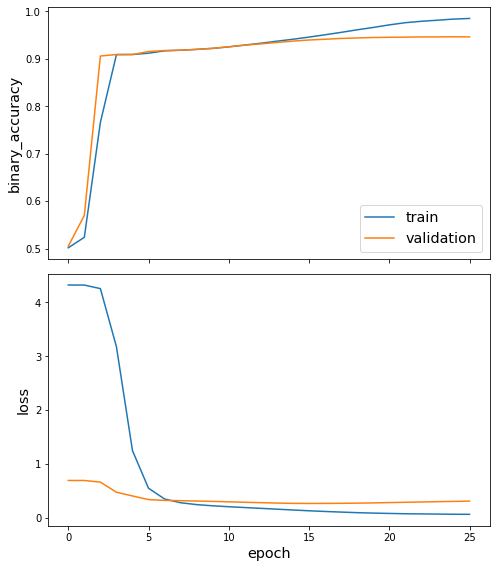

In [ ]:
utils.plot_history(wn18_history)

In [ ]:
wn18_raw_ranks, wn18_filtered_ranks = wn18_complex.rank_edges_against_all_nodes(
    wn18_gen.flow(reddit_test), reddit_edges_stellar
)

In [ ]:
def results_as_dataframe(name_to_results):
    return pd.DataFrame(
        name_to_results.values(),
        columns=["mrr", "hits at 1", "hits at 3", "hits at 10"],
        index=name_to_results.keys(),
    )


def summarise(name_to_ranks):
    return results_as_dataframe(
        {
            name: (
                np.mean(1 / ranks),
                np.mean(ranks <= 1),
                np.mean(ranks < 3),
                np.mean(ranks <= 10),
            )
            for name, ranks in name_to_ranks.items()
        }
    )

In [ ]:
summarise({"raw": wn18_raw_ranks, "filtered": wn18_filtered_ranks})

,mrr,hits at 1,hits at 3,hits at 10
raw,0.219177,0.161087,0.210276,0.330817
filtered,0.403561,0.366828,0.404056,0.468999
